In [16]:
# Simplified experimental setup, we will try to experiment with one/more additional crossover operator. We insert our own tau function as well

In [1]:
# Imports
import numpy as np
import inspect
import scipy.stats as sp
from queue import PriorityQueue
from operator import itemgetter 
from itertools import combinations
from itertools import combinations_with_replacement
from matplotlib import pyplot as plt
import copy
import math

In [2]:
# Vertex data object: identified by name
class Vertex:
    def __init__(self, name):
        self.name = name
        
# Edge data object: edge (frm -> to) with weight function 'tau'
class Edge:
    def __init__(self, frm, to, tau, length, dijkstra_weight=1):
        self.frm = frm
        self.to = to
        self.tau = tau
        self.length = length
        self.dijkstra_weight = dijkstra_weight
        
    # made dnorm absolute value to prevent negative weights. Is this ok?    
    def generate_dijkstra_weight(self, k):
        self.dijkstra_weight = abs(np.random.normal(self.tau(k, self.length), 0.8*self.tau(k, self.length)))
        return self.dijkstra_weight
        
    def __repr__(self):
        tau_str = str(inspect.getsourcelines(self.tau)[0])
        tau_str = tau_str.strip("['\\n']").split(" = ")[1]
        return f'\n({self.frm.name} -> {self.to.name}, {tau_str})'
    
# Graph data object
class Graph:
    def __init__(self):
        self.vertices = []
        self.edges = []
        
    def add_vertex(self, name):
        self.vertices.append(Vertex(name))
        
    def add_vertices(self, num_vertices, start_at_zero=False):
        for i in range(num_vertices):
            self.add_vertex(i+int(not start_at_zero))
            
    def get_vertex(self, name):
        return next(v for v in self.vertices if v.name == name)
    
    def get_edge(self, v1_name, v2_name):
        for e in self.edges:
            if e.frm.name == v1_name and e.to.name == v2_name:
                return e
            elif e.to.name == v1_name and e.frm.name == v2_name:
                return e
#             else:
#                 print('no edge found ', v1_name, ' ', v2_name)
        
        
    def add_edge(self, frm_name, to_name, tau, length):
        assert frm_name in [v.name for v in self.vertices], f'Vertex {frm_name} not in Graph'
        assert to_name in [v.name for v in self.vertices], f'Vertex {to_name} not in Graph'
        frm = self.get_vertex(frm_name)
        to = self.get_vertex(to_name)
        self.edges.append(Edge(frm, to, tau, length))
        
    def get_neighbors(self, vertex_name):
        assert vertex_name in [v.name for v in self.vertices], f'Vertex {vertex_name} not in Graph'
        neighbors = []
        for edge in self.edges:
            if edge.frm.name == vertex_name:
                neighbors.append(edge.to)
            if edge.to.name == vertex_name:
                neighbors.append(edge.frm)
        return neighbors
    
    def generate_dijkstra_weights(self, k):
        for edge in self.edges:
            edge.generate_dijkstra_weight(k)
            
    def get_average_neighbor_count(self):
        avg_count = 0
        for vertex in self.vertices:
            avg_count += len(self.get_neighbors(vertex.name))
        return avg_count / len(self.vertices)
    
    def __str__(self):
        return str(self.edges)

In [3]:
# Test graph parameters
tau_linear = lambda x, l: l*x
tau_constant = lambda x, l: l*2
num_vertices = 7
graph_test = Graph()

# Add vertices
graph_test.add_vertices(8)

# Add edges
graph_test.add_edge(1, 2, tau_linear, 1)
graph_test.add_edge(1, 3, tau_linear, 1)
graph_test.add_edge(1, 4, tau_linear, 1)
graph_test.add_edge(2, 6, tau_linear, 1)
graph_test.add_edge(3, 4, tau_linear, 1)
graph_test.add_edge(3, 8, tau_linear, 1)
graph_test.add_edge(4, 5, tau_linear, 1)
graph_test.add_edge(5, 8, tau_linear, 1)
graph_test.add_edge(6, 7, tau_linear, 1)
graph_test.add_edge(7, 8, tau_linear, 1)



In [4]:
# RandDijkstra
# k is continuous flow of drivers (real number > 0)
def rand_dijkstra(graph, source, target, k, overwrite_weights={}):
#     graph.generate_dijkstra_weights(k)
    
    D = {v.name:(float('inf'), None) for v in (graph.vertices)}
    D[source.name] = (0, None)
    visited = []

    pq = PriorityQueue()
    pq.put((0, source.name))

    while not pq.empty():
        (dist, current_vertex_name) = pq.get()
        visited.append(current_vertex_name)

        for neighbor in graph.get_neighbors(current_vertex_name):
            if neighbor not in visited:
                edge = graph.get_edge(current_vertex_name, neighbor.name)
                weight = None
                
                # Overwrite weights when edge exists in dictionary
                if (edge.frm.name, edge.to.name) in overwrite_weights:
                    weight = overwrite_weights[(edge.frm.name, edge.to.name)]
                elif (edge.to.name, edge.frm.name) in overwrite_weights:
                    weight = overwrite_weights[(edge.to.name, edge.frm.name)]
                else:
                    weight = edge.generate_dijkstra_weight(k)
                old_cost = D[neighbor.name][0]
                new_cost = D[current_vertex_name][0] + weight
                if new_cost < old_cost:
                    pq.put((new_cost, neighbor.name))
                    D[neighbor.name] = (new_cost, current_vertex_name)
                    
    prev = D[target.name][1]
    route_to_target = [target.name]
    while prev != None:
        route_to_target.insert(0, prev)
        prev = D[prev][1]
    
    return D[target.name][0], route_to_target

# print(rand_dijkstra(graph_test, graph_test.get_vertex(1), graph_test.get_vertex(8), 100))

In [5]:
#mutation operators: tuple of 4 operator functions
def multiple_router_EA(G, s, t, k, n, mu, cStra, mutation_ops, mut_ops_used=[0,1,2,3], max_it=200):
    P_st = []
    P = []
    weights = np.array([30, 60, 30, 15])[mut_ops_used]
    
    diversity_scores, travel_times = [], []
    ex_segment_threshold = int(0.2*max_it)
    ex_segment_incr = None
    
    for i in range(mu):
        ind = [rand_dijkstra(G, s, t, k)[1] for _ in range(n)]
        
        #our addition
        for route in ind:
            if route not in P_st:
                P_st.append(route)
        
        P.append(ind)
        
    for it in range(max_it):
        print(f'Progress {it}/{max_it}', end='\r')
        
        C = []
        for j in range(int(np.sqrt(mu**2-(mu/2)))):
            # choose uniformly at random chosen
            indices_inds = np.random.choice(range(len(P)), 2, replace=False)
            ind1 = P[indices_inds[0]]
            ind2 = P[indices_inds[1]]
            
            C.append(cStra(ind1, ind2))
        P_ = copy.deepcopy(P)
        for mut_index, ind in enumerate(P_):
            mutations = max(1, np.random.poisson(1.5))
            norm_weights = [float(w)/sum(weights) for w in weights]
            ops = np.random.choice(mutation_ops, size=mutations, p=norm_weights)
#             ops = [mutation_ops[0]]
                
            # Because exSegment is too expense: if it is in the list
            # we will discard all other operators
            if ex_segment in ops:
                ops = [ex_segment]
            
            for operator in ops:
                mutated_ind = operator(ind, P_st, G, s, t, k)
                
                # replace 
                P_[mut_index] = mutated_ind
                
        # Update weights
        if it >= 10 and 0 in mut_ops_used:
            new_route_index = mut_ops_used.index(0)
            weights[new_route_index] = 30 - (it-10)*(29/(max_it-10))
        if 3 in mut_ops_used and len(travel_times) > 0 and travel_times[-1] >= travel_times[max(0, len(travel_times)-ex_segment_threshold-1)]:
            ex_segment_index = mut_ops_used.index(3)
            if ex_segment_incr is None:
                ex_segment_incr = max_it-it
            weights[ex_segment_index] = 15 + it*(15/ex_segment_incr)
            
        # if no individual in 𝐶 is better than the best in 𝑃 then:
        C_travel_times = []
        for C_ind in C:
            f = calc_f(C_ind, P_st)
            travel_time = calculate_overall_travel_time(P_st, f, G)
            C_travel_times.append(travel_time)

        P_travel_times = []
        for P_ind in P:
            f = calc_f(P_ind, P_st)
            travel_time = calculate_overall_travel_time(P_st, f, G)
            P_travel_times.append(travel_time)
            
        P__travel_times = []
        for P__ind in P_:
            f = calc_f(P__ind, P_st)
            travel_time = calculate_overall_travel_time(P_st, f, G)
            P__travel_times.append(travel_time)

        if len(C) > 0 and max(C_travel_times) < max(P_travel_times):
            C = []
            C_travel_times = []
        
        # P = best mu individuals in C U P_ U P 
        # We assume that P, P_, C are not sets, so duplicates are NOT removed
        P_union = P + P_ + C 
        P_tt_union = P_travel_times + P__travel_times + C_travel_times
        
        
        # Sort P_union by P_tt_union
        tuple_P = [(tt, x) for tt, x in sorted(zip(P_tt_union, P_union), key=lambda tup: tup[0])][:mu]
        P = [x for _, x in tuple_P]
        travel_times.append(tuple_P[0][0])
        diversity_scores.append(diversity_score(P[0]))
        
    best_P = P[0]
    print('MPREA task finished')
    return best_P, travel_times, diversity_scores
        
        

        
def diversity_score(inds):
    edges_seen = []
    edges_counts = []
    for route in inds:
        for i in range(1,len(route)):
            e = (route[i-1], route[i])
            if not e in edges_seen:
                edges_seen.append(e)
                edges_counts.append(1)
            else:
                index = edges_seen.index(e)
                edges_counts[index] += 1
            
    
    top = [c**2 for c in edges_counts if c>1]
    bottom = [c for c in edges_counts if c==1]
    score = sum(top)/max(1,sum(bottom))
    
    if score == 0:
        return 0
    else:
        return 1/score
        
        

def exhaustive_crossover(ind1, ind2):
    inds = ind1+ind2
    n = len(ind1)
    
    list_combinations = list(combinations(inds,n))
    list_combinations = [list(x) for x in list_combinations]
    scores = list(map(diversity_score, list_combinations))
    arg = np.argmin(scores)
    return list_combinations[arg]

# Mutation Operators

In [6]:
def get_inverse_tf_probs(ind, P_st):  
    flows = calc_f(ind, P_st)
    sum_flows = sum(flows)  
    norm_flows = [v/sum_flows for v in flows]
    if 1.0 in norm_flows:
        if sum(norm_flows) > 1:
            print('error in get_inverse_tf_probs. More than one 1 in norm_flows')
        return norm_flows
    else:
        inv_flows = [1-v if v > 0 else 0 for v in norm_flows]
        return [i/sum(inv_flows) for i in inv_flows]

# Helper function to get random index in list for all els
def get_random_indices(list, els):
    indices_list = []
    for el in els:
        occurences = [i for i, e in enumerate(list) if e == el]
        indices_list.append(np.random.choice(occurences))
    return indices_list

# Helper function to remove cycles in route
def remove_cycles(route):
    new_route = []
    visited_vertices = []
    for i, v in enumerate(route):
        if v in visited_vertices:
            cycle_start = new_route.index(v)
            # Remove cycles vertices
            for v_r in new_route[cycle_start:i]:
                if v_r in visited_vertices:
                    visited_vertices.remove(v_r)
            new_route = new_route[:cycle_start] + new_route[i:]
        visited_vertices.append(v)
        new_route.append(v)
    return new_route
            
# pain and suffering
def NewRoute(ind, P_st, G, s, t, k):  
    probs = get_inverse_tf_probs(ind, P_st)
    P_st_index = np.random.choice(range(len(P_st)), p=probs)
    route = P_st[P_st_index]
    
    route_index = ind.index(route)
    
    new_route = rand_dijkstra(G, s, t, k)[1]
    ind[route_index] = new_route
    if new_route not in P_st:
        P_st.append(new_route)
    
    return ind


# Select a random route in ind. Select the highest flow edge in the route and find a route which
# circumvents the 'crowded' edge
def Roundabout(ind, P_st, G, s, t, k):
    f = calc_f(ind,P_st)
    index = np.random.choice(range(len(ind)))
    route = ind[index]
    
    max_edge = 0
    max_edge_flow = 0
    for vertex_i in range(len(route)-1):
        frm = route[vertex_i]
        to = route[vertex_i+1]
        edge = G.get_edge(frm,to)
        
        
        edge_flow = get_edge_traffic_flow(P_st,f,edge)
        if edge_flow >= max_edge_flow:
            max_edge = edge
            max_edge_flow = edge_flow
            
    frm = getattr(getattr(max_edge,'frm'),'name')
    
    neighbor_vertices = G.get_neighbors(frm)
    while leq_two_neighbors(neighbor_vertices):
        frm = get_previous_vertex(route,frm)
        neighbor_vertices = G.get_neighbors(frm)
    
    neighbors_names = [getattr(vert,'name') for vert in neighbor_vertices]
    #remove vertices which are connected through the crowded edge and the previous edge
    prev = get_previous_vertex(route,frm)
    to = getattr(getattr(max_edge,'to'),'name')
    
    if prev in neighbors_names:
        neighbors_names.remove(prev)
    if to in neighbors_names:
        neighbors_names.remove(to)
    
    new_vertex_name = np.random.choice(neighbors_names)
    new_vertex = G.get_vertex(new_vertex_name)
    frm_index = route.index(frm)
    route = route[:frm_index]
    redirection = rand_dijkstra(G, new_vertex, t, k)[1]
    
    new_route = route+[frm]+redirection
    new_route = remove_cycles(new_route)
    if not new_route in P_st:
        P_st.append(new_route)
    
    ind[index] = new_route
    
    return ind
    
# Mutation operator RandomP implementation
def random_P(ind, P_st, G, s, t, k):
    new_ind = ind.copy()
    
    probs = get_inverse_tf_probs(new_ind, P_st)
    route_subset_size = np.random.randint(1, len(new_ind))
    P_st_indices = np.random.choice(range(len(P_st)), size=route_subset_size, p=probs)
    route_subset = [P_st[P_st_index] for P_st_index in P_st_indices]
    route_indices = get_random_indices(ind, route_subset)

    for i, route in enumerate(route_subset):
        r = len(route)
        start_node_index = np.random.randint(r-2)
        subroute_length = max(min(abs(int(np.random.normal(0.25*r, 0.5*r))), r-start_node_index-1), 2)
        end_node_index = start_node_index + subroute_length
        subroute = route[start_node_index:end_node_index]
        overwrite_weights = {(edge.frm.name, edge.to.name):1000 for edge in get_edges(G, subroute)}
        new_subroute = rand_dijkstra(G, G.get_vertex(subroute[0]), G.get_vertex(subroute[-1]), k, overwrite_weights)[1]
        new_route = route[:start_node_index] + new_subroute + route[end_node_index:]
        new_route = remove_cycles(new_route)
        if not new_route in P_st:
            P_st.append(new_route)
        new_ind[route_indices[i]] = new_route
        
    return new_ind

# Mutation operator ExSegment implementation
def ex_segment(ind, P_st, G, s, t, k):
    new_ind = ind.copy()
    
    one_dim_list = [tuple(r) for r in ind]    
    num_diff_routes = len(set(one_dim_list))
    if num_diff_routes == 1:
        print('Ex segment early stop')
        return new_ind
    num_pair_els = np.random.randint(1, (num_diff_routes//2)+1) * 2
    route_pair_elements = np.random.choice(range(len(one_dim_list)), size=num_pair_els, replace=False)
    route_pairs = [(ind[route_pair_elements[i]], ind[route_pair_elements[i+1]]) for i in range(0, num_pair_els, 2)]
    
    # route_pairs = [([1, 2, 3, 4, 5, 6], [1, 7, 8, 9, 10, 3, 4, 11, 12, 13, 6])]
    
    for i, (r1, r2) in enumerate(route_pairs):
        if r1 != r2:
            r1_ind = route_pair_elements[i]
            r2_ind = route_pair_elements[i+1]
            r1_len = len(r1)
            r2_len = len(r2)
            # Compute divergence + goto index pairs
            div_pairs, goto_pairs = [], []
            for i, v1 in enumerate(r1):
                for j, v2 in enumerate(r2):
                    if v1 == v2 and i+1 < r1_len and j+1 < r2_len and r1[i+1] != r2[j+1]:
                        div_pairs.append((i, j))
                        break
                    elif v1 == v2 and i-1 > 0 and j-1 > 0 and r1[i-1] != r2[j-1]:
                        goto_pairs.append((i, j))
                        break
            # Randomly select div pair
            div_pair = div_pairs[np.random.choice(range(len(div_pairs)))]
            # Select goto pair occuring after div pair
            goto_pairs_after = [(i1, i2) for i1, i2 in goto_pairs if i1 > div_pair[0] and i2 > div_pair[1]]
            goto_pair = goto_pairs_after[np.random.choice(range(len(goto_pairs_after)))]
            # Swap
            new_r1 = r1[:div_pair[0]] + r2[div_pair[1]:goto_pair[1]] + r1[goto_pair[0]:]
            new_r2 = r2[:div_pair[1]] + r1[div_pair[0]:goto_pair[0]] + r2[goto_pair[1]:]
            if not new_r1 in P_st:
                P_st.append(new_r1)
            if not new_r2 in P_st:
                P_st.append(new_r2)
            new_ind[r1_ind] = new_r1
            new_ind[r2_ind] = new_r2
    
    return new_ind

def leq_two_neighbors(lst):
    return len(lst) <= 2

def get_previous_vertex(route, vertex):
    index = route.index(vertex)
    if index == 0:
        print('get_previous_vertex: is already the first vertex')
        return route[index]
    
    return route[index-1]
    

In [7]:
# Traffic Flow (f) = list of integers mapping index of route to drivers per unit

# Helper function that retrieves all edges in a route
def get_edges(graph, route):
    edges = []
    for i in range(len(route)-1):
        edges.append(graph.get_edge(route[i], route[i+1]))
    return edges


# Helper function to get traffic flow of edge given routes (P_st), traffic flow (f) and edge
def get_edge_traffic_flow(P_st, f, edge):
    value = 0
    for i, p in enumerate(P_st):
        for j in range(len(p)-1):
            if (p[j] == edge.frm.name and p[j+1] == edge.to.name) or (p[j+1] == edge.frm.name and p[j] == edge.to.name):
                value += f[i]
                break
    return value

# Function to calculate travel time
def calculate_travel_time(P_st, f, p, i, graph):
    f_p = f[i]
    tau_p = sum([edge.tau(get_edge_traffic_flow(P_st, f, edge), edge.length) for edge in get_edges(graph, p)])
    return f_p * tau_p

# Function to calculate overall travel time (C)
def calculate_overall_travel_time(P_st, f, graph):
    overall_travel_time = 0
    for i, p in enumerate(P_st):
        overall_travel_time += calculate_travel_time(P_st, f, p, i, graph)
    return overall_travel_time


# Possibly computationally inefficient if P_st is very large compared to ind
def calc_f(ind, P_st):
    f = []
    for existing_route in P_st:
        occurrence = 0
        for route in ind:
            if existing_route == route:
                occurrence += 1
        f.append(occurrence)
    return f

In [8]:
# Test graph parameters
tau_linear = lambda x, l: l*x
tau_constant = lambda x, l: l*1
num_vertices = 5
G = Graph()

# Add vertices
G.add_vertices(num_vertices)


# Add edges
G.add_edge(1, 2, tau_linear, 1)
G.add_edge(1, 3, tau_linear, 1)
G.add_edge(2, 4, tau_linear, 1)
G.add_edge(3, 4, tau_linear, 1)
G.add_edge(4, 5, tau_linear, 1)

s = G.get_vertex(1)
t = G.get_vertex(5)

k = 3

mu = 2

cStra = exhaustive_crossover

mutation_ops = [NewRoute, random_P, Roundabout, ex_segment]


P_st = [[1,2,4,5],[1,3,4,5]]
ind = [[1,2,4,5],[1,2,4,5],[1,3,4,5]]

ind = ex_segment(ind, P_st, G, s, t, k)

# f = calc_f(ind, P_st)
# calculate_overall_travel_time(P_st, f, G)
# lst = exhaustive_crossover(ind, ind)
# print(lst)

In [9]:
# multiple_router_EA(G, s, t, k, k, mu, cStra, mutation_ops, max_it=200)

In [10]:
# Tau functions
road_30 = lambda x, l: (50/l)*x**2
road_50 = lambda x, l: (25/l)*x**2
road_80 = lambda x, l: (10/l)*x**3
road_100 = lambda x, l: (2/l)*x**5

In [11]:
# Road network graph generator
def generate_road_network(
        num_vertices=200, 
        desired_neighbor_count=3.5, 
        primary_arch_alpha=16, 
        secondary_arch_alpha=32, 
        sub_arch_min=2, 
        sub_arch_max=5, 
        main_road=road_100,
        primary_arch_road=road_80,
        secondary_arch_road=road_50,
        random_road=road_30,
        seed=42
    ):
    np.random.seed(seed)
    G = Graph()
    G.add_vertices(num_vertices, start_at_zero=True)
    cur_vertex = 0
    
    # Create main road (source -> target)
    main_road_length = num_vertices//8
    for i in range(main_road_length):
        # Main road length between 2 km and 10 km
        road_length = np.random.randint(200, 1000)
        G.add_edge(i, i+1, main_road, road_length)
    cur_vertex = main_road_length + 1
    
    # Create primary + secondary arches
    primary_arch_length = num_vertices // primary_arch_alpha
    secondary_arch_length = num_vertices // secondary_arch_alpha
    max_arch_size = primary_arch_length + sub_arch_max * secondary_arch_length
    while cur_vertex + max_arch_size < num_vertices:
        # Add primary arch
        start_node, end_node = np.random.choice(range(main_road_length), size=2, replace=False)
        # Primary arch road length between 0.5 and 2 km
        G.add_edge(start_node, cur_vertex, primary_arch_road, np.random.randint(50, 200))
        G.add_edge(cur_vertex + primary_arch_length, end_node, primary_arch_road, np.random.randint(50, 200))
        for j in range(cur_vertex, cur_vertex + primary_arch_length):
            road_length = np.random.randint(50, 200)
            G.add_edge(j, j+1, primary_arch_road, road_length)
        # Add secondary arches
        num_secondary_arches = np.random.randint(sub_arch_min, sub_arch_max)
        primary_arch_start = cur_vertex
        primary_arch_end = primary_arch_start + primary_arch_length
        cur_vertex = primary_arch_end + 1
        for k in range(num_secondary_arches):
            arch_start_node, arch_end_node = np.random.choice(range(primary_arch_start, primary_arch_end), size=2, replace=False)
            # Secondary arch road length between 50 m and 500 m
            G.add_edge(arch_start_node, cur_vertex, secondary_arch_road, np.random.randint(5, 50))
            G.add_edge(cur_vertex + secondary_arch_length, arch_end_node, secondary_arch_road, np.random.randint(5, 50))
            for l in range(cur_vertex, cur_vertex + secondary_arch_length):
                road_length = np.random.randint(5, 50)
                G.add_edge(l, l+1, secondary_arch_road, road_length)
            cur_vertex = cur_vertex + secondary_arch_length + 1
            
            
    # Add connections
    for vertex_index in range(cur_vertex, num_vertices):
        # Random road length between 50 and 100 meters
        tiny_arch_start_node, tiny_arch_end_node = np.random.choice(range(0, cur_vertex), size=2, replace=False)
        G.add_edge(tiny_arch_start_node, vertex_index, random_road, np.random.randint(5, 10))
        G.add_edge(vertex_index, tiny_arch_end_node, random_road, np.random.randint(5, 10))
    
    # Add random connections
    while G.get_average_neighbor_count() <= desired_neighbor_count:
        v1_node, v2_node = np.random.choice(range(num_vertices), size=2, replace=False)
        G.add_edge(v1_node, v2_node, random_road, np.random.randint(5, 10))
        
    return G

In [12]:
road_nw = generate_road_network()

In [13]:
def plot_mrea_details(travel_times, diversity_scores):
    plt.xlabel('Iteration')
    plt.ylabel('Overall travel time')
    plt.plot(range(len(travel_times)), travel_times, color='blue')
    plt.show()
    plt.xlabel('Iteration')
    plt.ylabel('Diversity score')
    plt.plot(range(len(diversity_scores)), diversity_scores, color='red')
    plt.show()

from 192 to 163
MPREA task finished


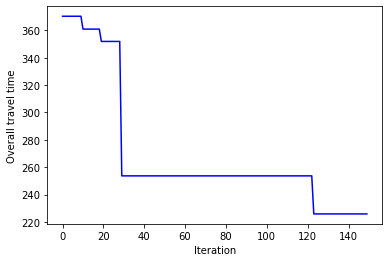

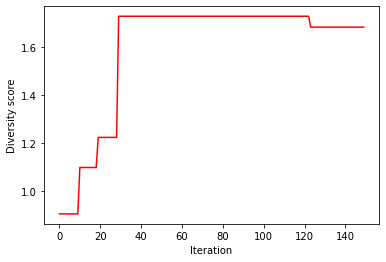

In [14]:
np.random.seed(41)
s, t = np.random.choice(road_nw.vertices, size=2)
k = 2000
mu = 1
n = 5
mutation_ops = [NewRoute, random_P, Roundabout, ex_segment]

print('from', s.name,'to',t.name)
best_P, travel_times, diversity_scores = multiple_router_EA(road_nw, s, t, k, n, mu, cStra, mutation_ops, max_it=150)

plot_mrea_details(travel_times, diversity_scores)

In [15]:
sp.pearsonr(travel_times, diversity_scores)

(-0.9463172890744063, 1.775250165213044e-74)

# Ablation testing code and multiple MREA code

In [16]:
def multiple_MREA_testing(runs, road_nw, s, t, k, n, mu, cStra, mutation_ops, mut_indices, max_it=150):
    tt_lists = []
    div_lists = []
    for i in range(runs):
        print('run', i+1, 'of', runs )
        comb_names, tt_list, div_list = multiple_router_EA(road_nw, s, t, k, n, mu, cStra, mutation_ops, mut_indices, max_it)
        tt_lists.append(tt_list)
        div_lists.append(div_list)
    tt_lists = np.array(tt_lists)
    div_lists = np.array(div_lists)

    return comb_names, tt_lists, div_lists
    

def ablation_testing(road_nw, s, t, k, n, mu, cStra, mutation_ops, max_it=150):
    mut_ops_combinations = get_all_combinations(mutation_ops)
    
    tt_list = []
    diversity_list = []
    combination_names = get_all_combinations(range(1,len(mutation_ops)+1))
    for i,muts in enumerate(mut_ops_combinations):
        mut_names = combination_names[i]
        mut_indices = [x-1 for x in mut_names]
        print('ablation ', i, 'of', len(mut_ops_combinations)-1, ':', mut_indices)
        best_P, travel_times, diversity_scores = multiple_router_EA(road_nw, s, t, k, n, mu, cStra, muts, mut_indices, max_it)
        tt_list.append(travel_times)
        diversity_list.append(diversity_scores)
    
    combination_names = get_all_combinations(range(1,len(mutation_ops)+1))
    
    return combination_names, tt_list, diversity_list

def get_all_combinations(lst):
    comb_list = []
    for i in range(1,len(lst)+1):
        combs = list(combinations(lst,i))
        for comb in combs:
            comb_list.append([x for x in comb])
    return comb_list


# names, tt, div = ablation_testing(road_nw, s, t, 3000, 2, mu, cStra, mutation_ops)

# Individual mutation operator performance testing

In [27]:
runs = 6
s, t = np.random.choice(road_nw.vertices, size=2)
G = generate_road_network()
mu = 1
print(s.name,t.name)

83 116


In [31]:
# mutation operator 0

mut_indices = [0]
mut_ops = np.array(mutation_ops)[mut_indices]

comb_names, tts_0, divs_0 = multiple_MREA_testing(runs, G, s, t, k, n, mu, cStra, mut_ops, mut_indices)

run 1 of 6
MPREA task finished
run 2 of 6
MPREA task finished
run 3 of 6
MPREA task finished
run 4 of 6
MPREA task finished
run 5 of 6
MPREA task finished
run 6 of 6
MPREA task finished


In [18]:
# mutation operator 1
mut_indices = [1]
mut_ops = np.array(mutation_ops)[mut_indices]

comb_names, tts_1, divs_1 = multiple_MREA_testing(runs, G, s, t, k, n, mu, cStra, mut_ops, mut_indices)

run 1 of 6
MPREA task finished
run 2 of 6
MPREA task finished
run 3 of 6
MPREA task finished
run 4 of 6
MPREA task finished
run 5 of 6
MPREA task finished
run 6 of 6
MPREA task finished


In [30]:
# mutation operator 2
mut_indices = [2]
mut_ops = np.array(mutation_ops)[mut_indices]

comb_names, tts_2, divs_2 = multiple_MREA_testing(runs, G, s, t, k, n, mu, cStra, mut_ops, mut_indices)

run 1 of 6
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
MPREA task finished
run 2 of 6
MPREA task finished
run 3 of 6
MPREA task finished
run 4 of 6
MPREA task finished
run 5 of 6
get_previous_vertex: is already the first vertex
MPREA task finished
run 6 of 6
MPREA task finished


In [28]:
# mutation operator 3
G = generate_road_network()
mut_indices = [3]
mut_ops = np.array(mutation_ops)[mut_indices]

comb_names, tts_3, divs_3 = multiple_MREA_testing(runs, G, s, t, k, n, mu, cStra, mut_ops, mut_indices)

run 1 of 6
MPREA task finished
run 2 of 6
MPREA task finished
run 3 of 6
MPREA task finished
run 4 of 6
MPREA task finished
run 5 of 6
MPREA task finished
run 6 of 6
MPREA task finished


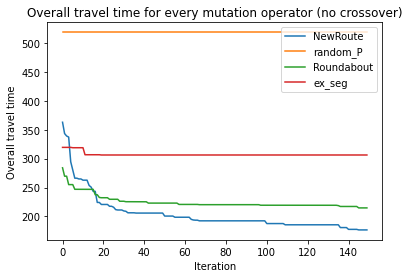

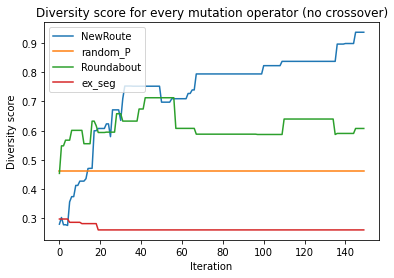

In [32]:
tt_0 = np.mean(tts_0, axis=0)
tt_1 = np.mean(tts_1, axis=0)
tt_2 = np.mean(tts_2, axis=0)
tt_3 = np.mean(tts_3, axis=0)

x = range(len(tt_0))

div_0 = np.mean(divs_0, axis=0)
div_1 = np.mean(divs_1, axis=0)
div_2 = np.mean(divs_2, axis=0)
div_3 = np.mean(divs_3, axis=0)



plt.plot(x, tt_0,label='NewRoute')
plt.plot(x, tt_1,label='random_P')
plt.plot(x, tt_2,label='Roundabout')
plt.plot(x, tt_3,label='ex_seg')
plt.xlabel('Iteration')
plt.ylabel('Overall travel time')
plt.legend()
plt.title('Overall travel time for every mutation operator (no crossover)')
plt.savefig('ind_travel_time.png')
plt.show()

plt.plot(x, div_0,label='NewRoute')
plt.plot(x, div_1,label='random_P')
plt.plot(x, div_2,label='Roundabout')
plt.plot(x, div_3,label='ex_seg')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Diversity score')
plt.title('Diversity score for every mutation operator (no crossover)')
plt.savefig('ind_diversity.png')
plt.show()

# Testing mutation operators with and without Roundabout for different connectivity graphs

In [47]:
max_ab = 6
s, t = np.random.choice(road_nw.vertices, size=2)
print(s.name,t.name)

194 163


In [42]:
# G1
G1 = generate_road_network(desired_neighbor_count=2)

mut_indices = [0,1,3]
mut_ops = np.array(mutation_ops)[mut_indices]
comb_names, G1_tts_without, G1_divs_without = multiple_MREA_testing(max_ab, G1, s, t, k, n, mu, cStra, mut_ops, mut_indices)

mut_indices = [0,1,2,3]
mut_ops = np.array(mutation_ops)[mut_indices]
comb_names, G1_tts_with, G1_divs_with = multiple_MREA_testing(max_ab, G1, s, t, k, n, mu, cStra, mut_ops, mut_indices)

run 1 of 6
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop

get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
MPREA task finished
run 2 of 6
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex

get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
MPREA task finished
run 6 of 6
get_previous_vertex: is already the fi

In [48]:
# G2
G2 = generate_road_network(desired_neighbor_count=3.5)

mut_indices = [0,1,3]
mut_ops = np.array(mutation_ops)[mut_indices]
comb_names, G2_tts_without, G2_divs_without = multiple_MREA_testing(max_ab, G2, s, t, k, n, mu, cStra, mut_ops, mut_indices)

mut_indices = [0,1,2,3]
mut_ops = np.array(mutation_ops)[mut_indices]
comb_names, G2_tts_with, G2_divs_with = multiple_MREA_testing(max_ab, G2, s, t, k, n, mu, cStra, mut_ops, mut_indices)

run 1 of 6
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
Ex segment early stop
MPREA task finished
run 2 of 6
MPREA task finished
run 3 of 6
MPREA task finished
run 4 of 6
MPREA task finished
run 5 of 6
MPREA task finished
run 6 of 6
MPREA task finished
run 1 of 6
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
MPREA task finished
run 2 of 6
get_previous_vertex: is already the first vertex
get_previous_vertex: is already the first vertex
get_previous_vertex: is a

In [44]:
# G3
G3 = generate_road_network(desired_neighbor_count=5)

mut_indices = [0,1,3]
mut_ops = np.array(mutation_ops)[mut_indices]
comb_names, G3_tts_without, G3_divs_without = multiple_MREA_testing(max_ab, G3, s, t, k, n, mu, cStra, mut_ops, mut_indices)

mut_indices = [0,1,2,3]
mut_ops = np.array(mutation_ops)[mut_indices]
comb_names, G3_tts_with, G3_divs_with = multiple_MREA_testing(max_ab, G3, s, t, k, n, mu, cStra, mut_ops, mut_indices)

run 1 of 6
Ex segment early stop
Ex segment early stop
Ex segment early stop


KeyboardInterrupt: 

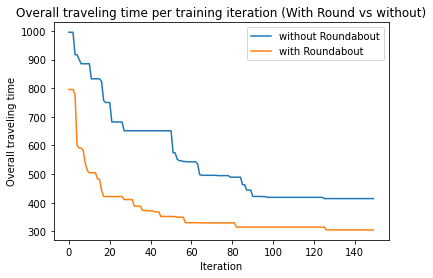

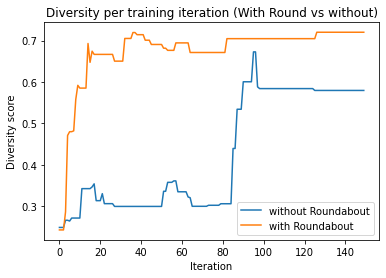

without (-0.7562257546857313, 4.6916613450586494e-29)
with (-0.9424669656205993, 2.591159498391025e-72)


In [49]:
tt_without = np.mean(G2_tts_without, axis=0)
tt_with = np.mean(G2_tts_with, axis = 0)

div_without = np.mean(G2_divs_without, axis = 0)
div_with = np.mean(G2_divs_with, axis = 0)

x = range(len(tt_with))

plt.plot(x, tt_without,label='without Roundabout')
plt.plot(x, tt_with,label='with Roundabout')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Overall traveling time')
plt.title('Overall traveling time per training iteration (With Round vs without)')
plt.savefig('avg_tt.png')
plt.show()


plt.plot(x, div_without,label='without Roundabout')
plt.plot(x, div_with,label='with Roundabout')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Diversity score')
plt.title('Diversity per training iteration (With Round vs without)')
plt.savefig('avg_div.png')
plt.show()


print('without', sp.pearsonr(tt_without, div_without))
print('with', sp.pearsonr(tt_with, div_with))

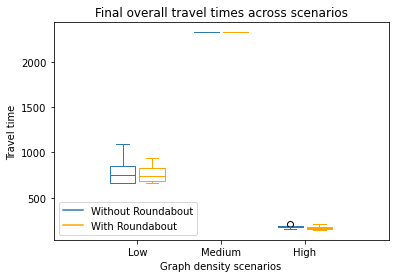

In [37]:
tt_without = [G1_tts_without[:,-1], G2_tts_without[:,-1], G3_tts_without[:,-1]]
tt_with = [G1_tts_with[:,-1], G2_tts_with[:,-1], G3_tts_with[:,-1]]
 
ticks = ['Low', 'Medium', 'High']
 
without_plot = plt.boxplot(tt_without, positions=np.array(np.arange(len(tt_without))*2.0-0.35), widths=0.6)
with_plot = plt.boxplot(tt_with, positions=np.array(np.arange(len(tt_with))*2.0+0.35), widths=0.6)
 

def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()
 
 
# setting colors for each groups
define_box_properties(without_plot, '#2C7BB6', 'Without Roundabout')
define_box_properties(with_plot, 'orange', 'With Roundabout')
 
# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
 
# set the limit for x axis
plt.xlim(-2, len(ticks)*2)
plt.ylabel('Travel time')
plt.xlabel('Graph density scenarios')

 
# set the title
plt.title('Final overall travel times across scenarios')
plt.savefig('boxplots.png')

# MU test

In [34]:
# Changing mu test
mutation_ops = [NewRoute, random_P, Roundabout, ex_segment]
max_ab = 6
k = 200
mu = 1
n = 2
s, t = np.random.choice(road_nw.vertices, size=2)
G = generate_road_network(desired_neighbor_count=3.5)
print(s.name,t.name)

# mu = 1
mu = 1

mut_indices = [0,1,3]
mut_ops = np.array(mutation_ops)[mut_indices]
_, mu1_tts_without, mu1_divs_without = multiple_MREA_testing(max_ab, G, s, t, k, n, mu, cStra, mut_ops, mut_indices)

mut_indices = [0,1,2,3]
mut_ops = np.array(mutation_ops)[mut_indices]
_, mu1_tts_with, mu1_divs_with = multiple_MREA_testing(max_ab, G, s, t, k, n, mu, cStra, mut_ops, mut_indices)

# mu = 2
mu = 2

mut_indices = [0,1,3]
mut_ops = np.array(mutation_ops)[mut_indices]
_, mu2_tts_without, mu2_divs_without = multiple_MREA_testing(max_ab, G, s, t, k, n, mu, cStra, mut_ops, mut_indices)

mut_indices = [0,1,2,3]
mut_ops = np.array(mutation_ops)[mut_indices]
_, mu2_tts_with, mu2_divs_with = multiple_MREA_testing(max_ab, G, s, t, k, n, mu, cStra, mut_ops, mut_indices)

# mu = 4
mu = 4

mut_indices = [0,1,3]
mut_ops = np.array(mutation_ops)[mut_indices]
_, mu4_tts_without, mu4_divs_without = multiple_MREA_testing(max_ab, G, s, t, k, n, mu, cStra, mut_ops, mut_indices)

mut_indices = [0,1,2,3]
mut_ops = np.array(mutation_ops)[mut_indices]
_, mu4_tts_with, mu4_divs_with = multiple_MREA_testing(max_ab, G, s, t, k, n, mu, cStra, mut_ops, mut_indices)

83 116
run 1 of 6
MPREA task finished
run 2 of 6
MPREA task finished
run 3 of 6
MPREA task finished
run 4 of 6
MPREA task finished
run 5 of 6
MPREA task finished
run 6 of 6
MPREA task finished
run 1 of 6
MPREA task finished
run 2 of 6
MPREA task finished
run 3 of 6
MPREA task finished
run 4 of 6
MPREA task finished
run 5 of 6
MPREA task finished
run 6 of 6
MPREA task finished
run 1 of 6
MPREA task finished
run 2 of 6
MPREA task finished
run 3 of 6
MPREA task finished
run 4 of 6
MPREA task finished
run 5 of 6
MPREA task finished
run 6 of 6
MPREA task finished
run 1 of 6
MPREA task finished
run 2 of 6
get_previous_vertex: is already the first vertex
MPREA task finished
run 3 of 6
MPREA task finished
run 4 of 6
MPREA task finished
run 5 of 6
MPREA task finished
run 6 of 6
MPREA task finished
run 1 of 6
MPREA task finished
run 2 of 6
MPREA task finished
run 3 of 6
MPREA task finished
run 4 of 6
MPREA task finished
run 5 of 6
MPREA task finished
run 6 of 6
MPREA task finished
run 1 of 6
MPR

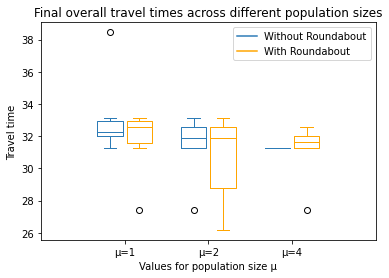

In [37]:
tt_without = [mu1_tts_without[:,-1], mu2_tts_without[:,-1], mu4_tts_without[:,-1]]
tt_with = [mu1_tts_with[:,-1], mu2_tts_with[:,-1], mu4_tts_with[:,-1]]
 
ticks = ['μ=1', 'μ=2', 'μ=4']
 
without_plot = plt.boxplot(tt_without, positions=np.array(np.arange(len(tt_without))*2.0-0.35), widths=0.6)
with_plot = plt.boxplot(tt_with, positions=np.array(np.arange(len(tt_with))*2.0+0.35), widths=0.6)
 

def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()
 
 
# setting colors for each groups
define_box_properties(without_plot, '#2C7BB6', 'Without Roundabout')
define_box_properties(with_plot, 'orange', 'With Roundabout')
 
# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
 
# set the limit for x axis
plt.xlim(-2, len(ticks)*2)
plt.ylabel('Travel time')
plt.xlabel('Values for population size μ')

 
# set the title
plt.title('Final overall travel times across different population sizes')
plt.savefig('boxplots_mu.png')

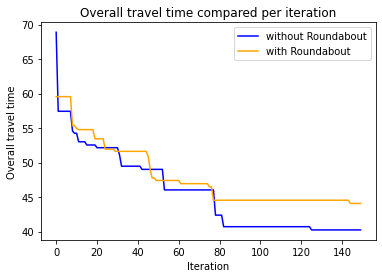

In [156]:
x = range(len(without_tt_mean))

plt.plot(x, without_tt_mean, label='without Roundabout', color='blue')
plt.plot(x, with_tt_mean, label='with Roundabout', color='orange')

# plt.fill_between(x, without_tt_mean+without_tt_sd, without_tt_mean-without_tt_sd, facecolor='blue', alpha=0.2)
# plt.fill_between(x, with_tt_mean+with_tt_sd, with_tt_mean-with_tt_sd, facecolor='orange', alpha=0.2)


plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Overall travel time')
plt.title('Overall travel time compared per iteration')
plt.show()

plt.savefig('')


